<a href="https://colab.research.google.com/github/Ksangeetha801/Lyme-Disease-Detection/blob/main/week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries loaded.
Loaded dataset shape: (10000, 13)
   CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  Num Of Products  Has Credit Card  Is Active Member  \
0       0.00                1                1                 1   
1   83807.86                1                0                 1   
2  159660.80                3                1                 0   
3       0.00                2                0                 0   
4  125510.82                1                1                 1   

   Estimated Salary  Churn  
0         101348.88      1  
1         112542.58      0  
2         113931.57      

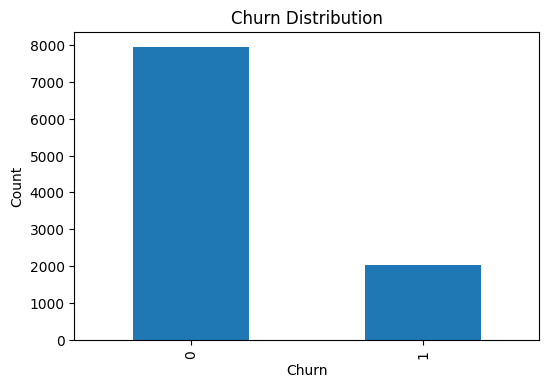

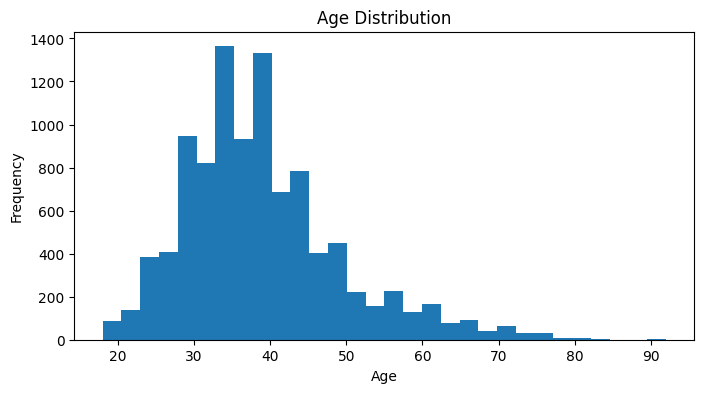

/tmp/ipython-input-2617806551.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[df['Churn']=='No']['Balance'], df[df['Churn']=='Yes']['Balance']], labels=['Stayed','Exited'])


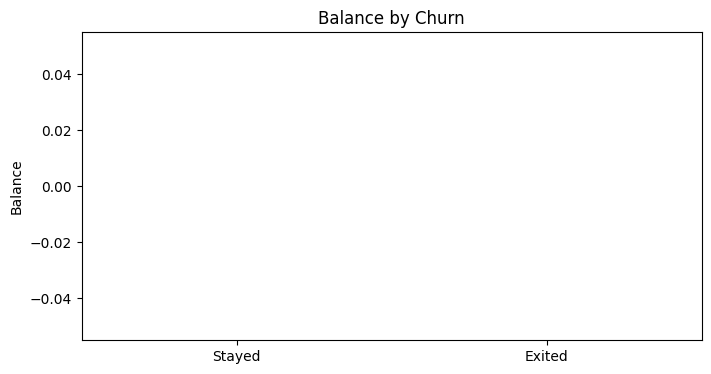


Decision Tree Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1593
           1       0.57      0.49      0.53       407

    accuracy                           0.82      2000
   macro avg       0.72      0.70      0.71      2000
weighted avg       0.81      0.82      0.82      2000


KNN Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1593
           1       0.66      0.35      0.45       407

    accuracy                           0.83      2000
   macro avg       0.75      0.65      0.68      2000
weighted avg       0.81      0.83      0.81      2000


SVM Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1593
           1       0.84      0.39      0.53       407

    accuracy                           0.86      2000
   macro avg       0.85      0.69      0.73      2000
weighted avg       0.86  

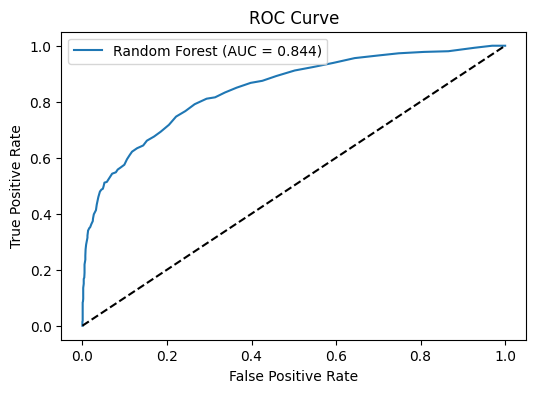

In [1]:
# 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

print('Libraries loaded.')

# 1. Load dataset
url = 'https://raw.githubusercontent.com/YBI-Foundation/Dataset/main/Bank%20Churn%20Modelling.csv'
df = pd.read_csv(url)
print('Loaded dataset shape:', df.shape)
print(df.head())

# 2. Quick info & missing values
print(df.info())
print('\nMissing values per column:\n', df.isnull().sum())
print('\nTarget distribution:')
print(df['Churn'].value_counts())

# 3. EDA - Basic plots
plt.figure(figsize=(6,4))
df['Churn'].value_counts().plot(kind='bar')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df['Age'].dropna(), bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,4))
plt.boxplot([df[df['Churn']=='No']['Balance'], df[df['Churn']=='Yes']['Balance']], labels=['Stayed','Exited'])
plt.title('Balance by Churn')
plt.ylabel('Balance')
plt.show()

# 4. Preprocessing
X = df.drop(columns=['Churn'])
y = df['Churn']

# Convert target labels Yes/No to 1/0
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical & numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Models to try
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# 7. Train and evaluate
results = {}

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1] if hasattr(clf.named_steps['classifier'], "predict_proba") else None

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred))

# 8. Results summary
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df)

# 9. ROC Curve for best model (Random Forest as example)
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier(random_state=42))])
best_model.fit(X_train, y_train)
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='Random Forest (AUC = %.3f)' % roc_auc_score(y_test, y_prob))
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
